Next generation sequencing [1] is causing an explosion in the amount of data generated by the field of genomics. The field is ripe for analysis with the tools of Big Data and Data Science. 

For dealing with data in my current field of biophysics, I've recently developed an obsession with the subset of unsupervised learning known as clustering. Specifically, I'm interested in clustering techniques that either don't require arbitrary parameter selection or can be adapted to eliminate the need for a human to make a choice. Rather than having a user select parameters for analyzing the data, I want the data to speak for itself.

This summer, my research group (http://salsburygroup.squarespace.com/) submitted a paper [2] on two modern clustering techniques -- HDBSCAN and Amorim-Hennig -- applied to Molecular Dynamics (MD) data. In MD, we simulate the movement of small molecules using classical physics (no quantum mechanics). These simulations generate hundreds of gigabytes worth of data -- far more than a person could ever sift through. 

With the relatively close relationships between biophysics (my field) and genomics, my advisor suggested applying these clustering techniques to gene expression data with the hope of identifying patient subtypes without the need for any arbitrary parameter setting by a human. 

The initial results are negative. The two non-parametric clustering techniques that worked well for MD [2], perform essentially as well as random selection on genomics data. Using six small, (~100 samples each) labeled,  publicly available data from the Broad Institute's Cancer Program  http://portals.broadinstitute.org/cgi-bin/cancer/datasets.cgi, I clustered multiple sets of gene expression data from cancer patients using three clustering techniques available in Scikt-Learn [3] along with the two techniques discussed in my paper [2]. Since the data from the Broad Institute was labeled, I was able to score the clustering algorithms on how well they did relative to the true categories in the data, using the Adjusted Rand Index [4]. Since the results are negative and unlikely to be published otherwise, I report them here.

**NOTE**: *It turns out the labels I assumed to be correct were generated using agglomerative hierachical clustering. I didn't realize the label-generation method when I first started playing with this data. So, I can expect that my final scores won't actually be an indication of how well the clustering methods I try fit the data, since the labels for the data was created with another clustering technique. However, I decided to still report this work since it shows the usage of clustering techniques and cluster evaluation metrics.*

In [1]:
# Required packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from glob import glob

from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import hdbscan as hd
from Analysis.Cluster.Clusterer import IMWKRescaled


import warnings
warnings.filterwarnings('ignore') 

## Labeled data
Hoshida, et al., 2007[5], reports on attempts to identify subclasses within genomics data. That is, they wanted to pick out sets of patients across various types of genomics data. 

As a byproduct of their work, they produces labeled sets of genomics data. Assuming their labels are correct (which, as it turns out may not be a good assumption -- more on that later), I can test some well-established clustering techniques along with the two recently developed techniques -- HDBSCAN and Amorim-Hennig -- that I discuss in my recently submitted work[2]. 

I've already downloaded their data, now I'll create numpy arrays of both the data sets and their corresponding labels. 

**It turns out the labels were generated using agglomerative hierachical clustering. I didn't realize the label-generation method when I first started playing with this data. So, I can expect that my final scores won't actually be an indication of how well the clustering methods I try fit the data, since the labels for the data was created with another clustering technique. However, I decided to still report this work since it shows the usage of clustering techniques and cluster evaluation metrics.**

In [2]:
# Data from http://portals.broadinstitute.org/cgi-bin/cancer/datasets.cgi

# load data
datasets = []
labels = []
for file in glob('./raw_data/*.gct'):
    data = np.genfromtxt(file, skip_header=4, missing_values=0)
    data = np.delete(data, [0,1], 1)
    data = data.transpose()
    datasets.append(data)
    file = file.replace('gct', 'cls')
    label = np.genfromtxt(file, skip_header=2)
    labels.append(label)

## Non-parametric clustering
I'm interested[2] in non-parametric clustering as a way to remove the bias created by human parameter selection. I want either automated, reproducible parameter selection or the elimination of tunable parameters all together. Some may say that I'm a dreamer, but hopefully I'm not the only one.

The python machine learning package scikit-learn[3] has, as of this writing, three built-in clustering techniques with either sensible default parameters or automated ways of setting parameters based on a data set. These clustering techniques are *Affinity Propagation*[6], which send signals across data points to map out a likely structure of the data; *Mean Shift*[7], which tries to find Gaussian-like distributions of points within the data and calls each of those distributions a cluster; and *DBSCAN*[8], which uses the local densities of points to identify likely subsets of data. The application of these methods from scikit-learn is based on a tutorial in the scikit-learn documentation, which can be found at http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html.

I'll also test two clustering techniques HDBSCAN[9], which is a hierarchical variant of DBSCAN and Amorim-Hennig[10] which is an iterative variate of K-Means that rescales data based on each previous iteration. For full details, see the papers on them cited here or my work applying them to simulations of biopolymers[2].

Here I'll loop through each technique and plot the results. These visualizations aren't the greatest, as they are two-dimensional projections of roughly 100-dimensional data. Each row is a data set, and each column is a clustering method. The colors of the points represent which cluster they belong to (so, say, all blue points are in the same cluster).

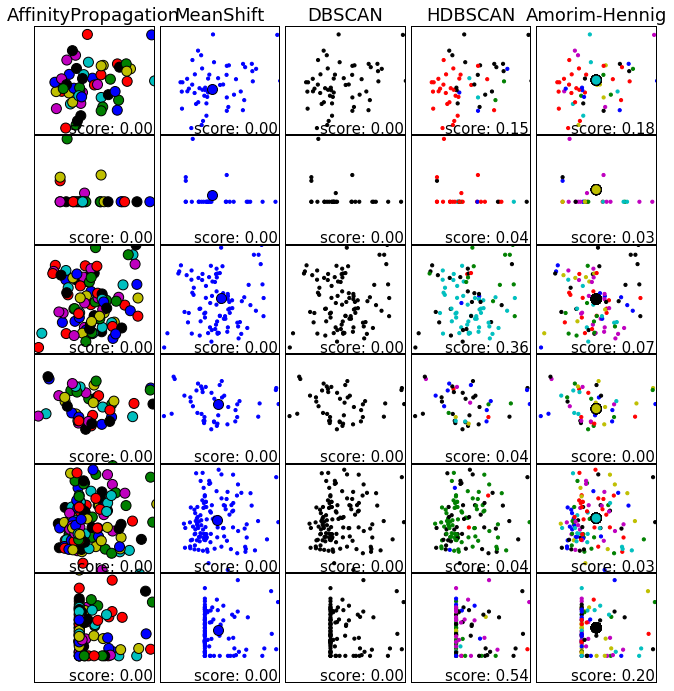

In [3]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'AffinityPropagation', 'MeanShift', 'DBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, dataset in enumerate(datasets):
    X = dataset
    y = labels[i_dataset]
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X,)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)



    clustering_algorithms = [ affinity_propagation, ms, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        score = metrics.adjusted_rand_score(y_pred, y)

        # plot
        plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('score: %.2f' % (score)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
    # Also do HDBSCAN and A-H
    # HDBSCAN 
    algorithm = hd.HDBSCAN(min_cluster_size=2)
    y_pred = algorithm.fit_predict(X)
    score = metrics.adjusted_rand_score(y_pred, y)
    plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
    if i_dataset == 0:
        plt.title('HDBSCAN', size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

    if hasattr(algorithm, 'cluster_centers_'):
        centers = algorithm.cluster_centers_
        center_colors = colors[:len(centers)]
        plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('score: %.2f' % (score)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
    plot_num += 1
    
    # A-H 
    algorithm = IMWKRescaled(X)
    y_pred, centers = algorithm.fit()
    score = metrics.adjusted_rand_score(y_pred, y)
    plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
    if i_dataset == 0:
        plt.title('Amorim-Hennig', size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('score: %.2f' % (score)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
    plot_num += 1

plt.show()

## Results and discussion
Each row is a data set, and each column is a clustering method. The colors of the points represent which cluster they belong to. The score for each clustering technique on each data set is based on how well they did relative to the true categories in the data, using the Adjusted Rand Index [4], which ranges from -1 to 1. A score of -1 indicates that the labels the clustering algorithm assigned and the true labels are completely independent (no correlation). A acore of 0 means that the clustering method did just as well as a random labeling would have. A score of 1 means the clustering algorithm created the same partitions as the true labels. 

Overall, the scikit-learn clustering techniques did as well as a random clustering (Adjusted Rand Index of 0). HDBSCAN and Amorim-Hennig, both did slightly better, with HDBSCAN performing the best on the final data set. 

As it turns out, and as I've added above, the original labels were themselves assigned by a clustering method, so they are not in fact the "true" labels for the data. I'll need to try this computational experiment again once I find better-labeled genomics data.

### References
[1] Mardis, E. R. (2008). The impact of next-generation sequencing technology on genetics. Trends in Genetics, 24(3), 133–141. http://doi.org/10.1016/j.tig.2007.12.007

[2] Melvin, R. L., Godwin, R. C., Xiao, J., Thompson, W. G., Berenhaut, K. S., Salsbury, F. R. Uncovering large-scale conformational change in molecular dynamics without prior knowledge. Journal Of Chemical Theory and Computation. Submitted.

[3] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2012). Scikit-learn: Machine Learning in Python, 12, 2825–2830. Retrieved from http://arxiv.org/abs/1201.0490

[4] Hubert, L., & Arabie, P. (1985). Comparing partitions. Journal of Classification, 2(1), 193–218. http://doi.org/10.1007/BF01908075

[5] Hoshida, Y., Brunet, J. P., Tamayo, P., Golub, T. R., & Mesirov, J. P. (2007). Subclass mapping: Identifying common subtypes in independent disease data sets. PLoS ONE, 2(11). http://doi.org/10.1371/journal.pone.0001195

[6] Zhang, X., Furtlehner, C., & Sebag, M. (2008). Data streaming with affinity propagation. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 5212 LNAI(PART 2), 628–643. http://doi.org/10.1007/978-3-540-87481-2_41

[7] Comanicu, D., & Meer, P. (2002). Mean shift: A robust approach toward feature space analysis. IEEE Trans. Pattern Anal. Machine Intell., 24(5), 603–619. http://doi.org/10.1109/34.1000236

[8] Ester, M., Kriegel, H.-P., Sander, J., Xu, X., & others. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, pp. 226–231). inproceedings.

[9] Campello, R. J. G. B., Moulavi, D., & Sander, J. (2013). Density-Based Clustering Based on Hierarchical Density Estimates. In Advances in Knowledge Discovery and Data Mining (pp. 160–172). http://doi.org/10.1007/978-3-642-37456-2_14

[10] De Amorim, R. C., & Hennig, C. (2015). Recovering the number of clusters in data sets with noise features using feature rescaling factors. Information Sciences, 324(February 2016), 126–145. http://doi.org/10.1016/j.ins.2015.06.039